### Classification in Business - Wine Quality Prediction 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, average_precision_score, precision_recall_curve, roc_curve, f1_score, roc_auc_score, ConfusionMatrixDisplay, make_scorer

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol wine_type  quality_class  
0      9.4       red              0  
1      9.8

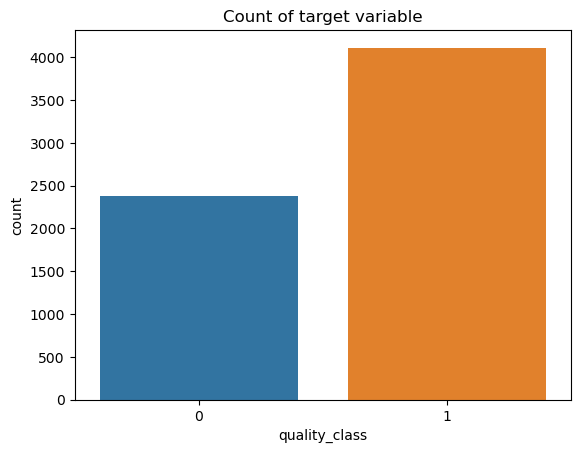

In [70]:
# Data EDA and PreProcessing
df_red = pd.read_csv('data/winequality-red.csv', sep=';')
df_white = pd.read_csv('data/winequality-white.csv', sep=';')
df_red['wine_type'] = 'red'
df_white['wine_type'] = 'white'

# print(df_red.head())
# print(df_white.head())

# Combine red and white wine data frames with wine type indicating if its red or white
df_wine = pd.concat([df_red, df_white], ignore_index=True)

# Convert quality score to a binary class. Have a new column for quality_class and drop quality
# class 0 = quality scores 0-5
# class 1 = quality scores 6-10
df_wine['quality_class'] = df_wine['quality'].apply(lambda x: 1 if x >= 6 else 0)
df_wine.drop(columns=['quality'], inplace=True)

print(df_wine.head())

# Any missing values in rows and columns? None found 
cols_missing_values = df_wine.isnull().sum()
print(cols_missing_values)

rows_with_missing_values = df_wine[df_wine.isnull().any(axis=1)]
print(rows_with_missing_values)


print(df_wine.info())

# Count Plot of target = quality_class where class 0 = score of 0-5, class 1 = score of 6-10
sns.countplot(data=df_wine, x = 'quality_class')
plt.title('Count of target variable');


In [35]:
# Make test/train dataset
X_train, X_test, y_train, y_test = train_test_split(df_wine.drop(['quality_class'], axis = 1), df_wine['quality_class'], random_state = 442,
                                                   stratify = df_wine['quality_class'])

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Value counts of 'y' in y_train and y_test
y_train.value_counts(normalize = True)
y_test.value_counts(normalize=True)

X_train shape: (4872, 12)
X_test shape: (1625, 12)
y_train shape: (4872,)
y_test shape: (1625,)


quality_class
1    0.633231
0    0.366769
Name: proportion, dtype: float64

In [71]:
# Make a column transformer - scale all numerics and one hot encode object types
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer((OneHotEncoder(drop ='first'), selector),
                                     remainder=StandardScaler())

# Select features 
extractor = SelectFromModel(LogisticRegression(penalty = 'l1', C= 0.1, solver='liblinear', random_state=43))

                            
# Make a pipeline with transformer, extractor, and a LogisticRegression estimator
lgr_pipe = Pipeline([('transformer', transformer),
                    ('extractor', extractor),
                    ('model', LogisticRegression(random_state=42, max_iter = 100, C=1.0))])

# Configure sklearn to display pipelines as diagrams
set_config(display='diagram')

# Display the pipeline
lgr_pipe


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x174570a10>)])),
                ('extractor',
                 SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                              penalty='l1',
                                                              random_state=43,
                                                              solver='liblinear'))),
                ('model', LogisticRegression(random_state=42))])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'extractor__estimator__C': 1.0, 'model__C': 1.0, 'model__penalty': 'l2'}
Best F1 Score: 0.8068173486174984
Features and Coefficients in Decreasing Order:
                            Feature  Coefficient
0                remainder__alcohol     0.922168
1         remainder__residual sugar     0.609116
2              remainder__sulphates     0.341504
3    remainder__free sulfur dioxide     0.262703
4                     remainder__pH     0.138923
5          remainder__fixed acidity     0.128294
6              remainder__chlorides    -0.026042
7            remainder__citric acid    -0.059359
8   remainder__total sulfur dioxide    -0.316096
9                remainder__density    -0.482005
10   onehotencoder__wine_type_white    -0.674559
11      remainder__volatile acidity    -0.781906
AUC Score: 0.8030602461502339


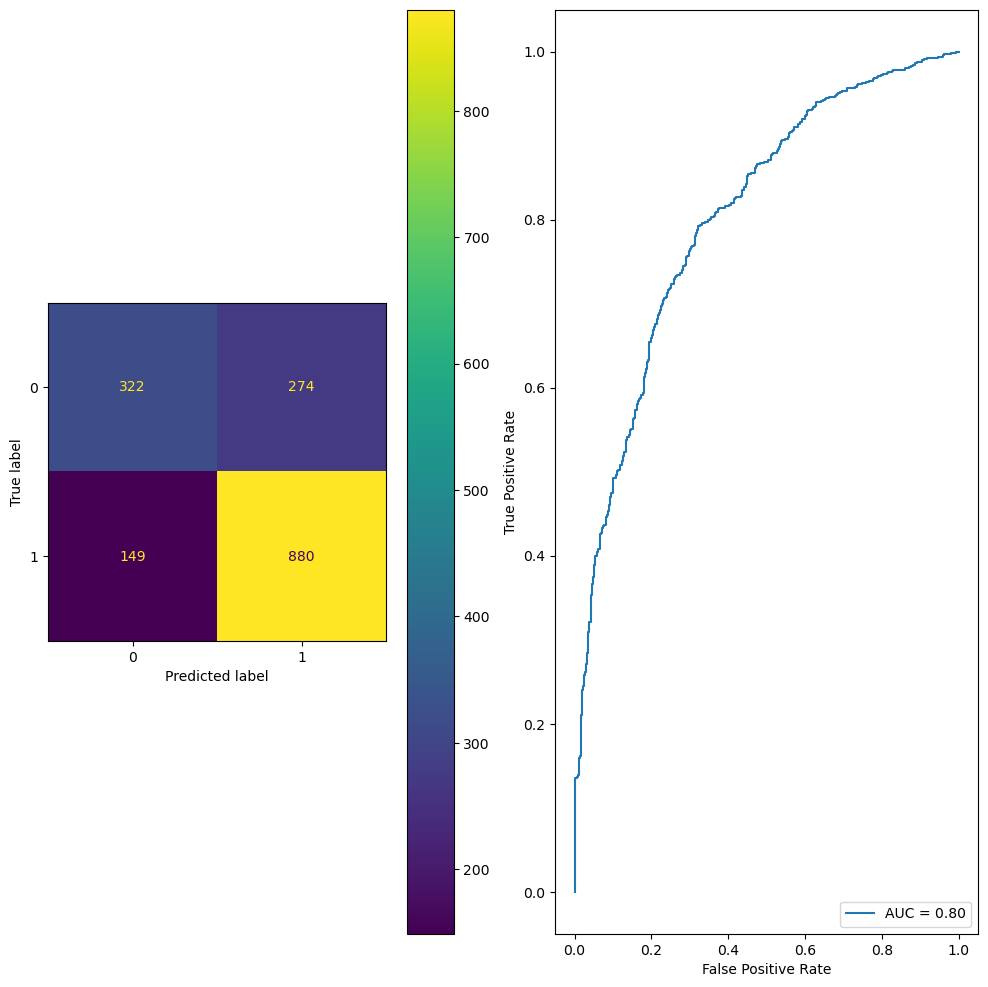

In [72]:

# Define the parameter grid for GridSearchCV
param_grid = {
    'model__C': [0.1, 1.0, 10.0],                 # Regularization parameter
    'model__penalty': ['l1', 'l2'],               # Penalty norm
    'extractor__estimator__C': [0.1, 1.0, 10.0],  # C parameter for SelectFromModel
}

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with scoring as 'f1' 
wine_grid = GridSearchCV(estimator=lgr_pipe, param_grid=param_grid, cv=skf, scoring='f1', verbose=1, n_jobs=-1)
wine_grid.fit(X_train, y_train)                                    
                            
# Print best parameters and best score found during grid search
print("Best Parameters:", wine_grid.best_params_)
print("Best F1 Score:", wine_grid.best_score_)

# Access the fitted SelectFromModel from the best estimator
best_estimator = wine_grid.best_estimator_
best_extractor = best_estimator.named_steps['extractor']

# Transform the data to get selected features
best_extractor.fit(X_transformed, y_train)
selected_indices = best_extractor.get_support()

# Get feature names from transformed data
feature_names = best_estimator.named_steps['transformer'].get_feature_names_out()
all_feature_names = list(feature_names) 

# Get the selected features
selected_feature_names = [all_feature_names[i] for i in range(len(all_feature_names)) if selected_indices[i]]


# Print coefficients of the selected features from the final model
model_coefficients = best_estimator.named_steps['model'].coef_[0]
selected_coefficients = model_coefficients[selected_indices]

# Create a DataFrame to display features and coefficients
features_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': selected_coefficients
})

# Sort the DataFrame by coefficients in decreasing order
features_df = features_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

print("Features and Coefficients in Decreasing Order:")
print(features_df)
    
# Confusion Matrix and ROC Curve
from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = best_estimator.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = best_estimator.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)
print("AUC Score:", roc_auc_value)

disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

